In [4]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os

In [5]:
path_data = './data'

In [6]:
os.listdir(path_data)

['models',
 'seg_pred',
 'seg_test',
 'seg_train',
 'seg_val',
 'train_df',
 'val_df']

In [7]:
train_path = os.path.join(path_data,'train_df/seg_train')
val_path = os.path.join(path_data,'val_df/seg_val')

In [8]:
os.listdir(val_path)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

## Fast AI

In [39]:
from fastai.vision.all import *

In [40]:

data = ImageDataLoaders.from_folder(
    path_data,
    train='seg_train',
    valid='seg_test',
    item_tfms=Resize(225),
    batch_tfms=aug_transforms(),
    num_workers=8,
    bs = 64,
    prefetch = True, #untuk memastikan data sudah siap sebelum model membutuhkannya. Ini akan mengurangi waktu tunggu antara setiap batch.
)


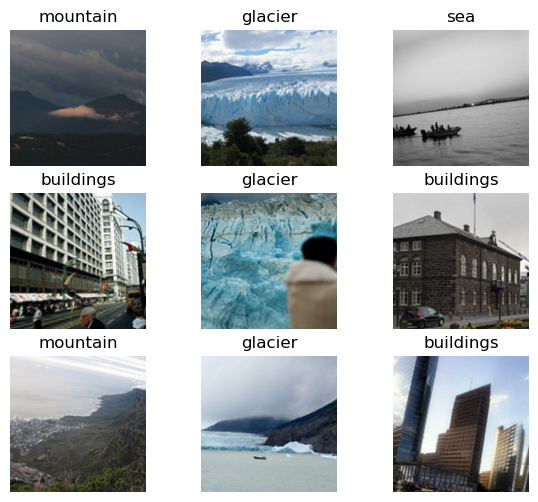

In [41]:
data.show_batch(max_n=9, nrows=3, figsize=(7,6))

In [42]:
print(data.vocab)
print(len(data.vocab))
data.c

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
6


6

In [43]:
model = vision_learner(data, resnet50, metrics = accuracy )

In [44]:
# Untuk PyTorch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

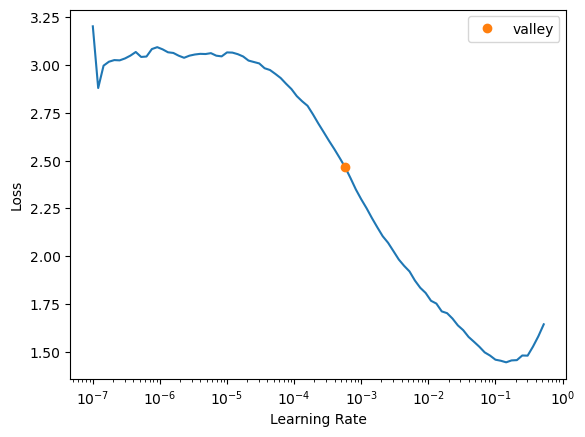

In [45]:
best_lr = model.lr_find()

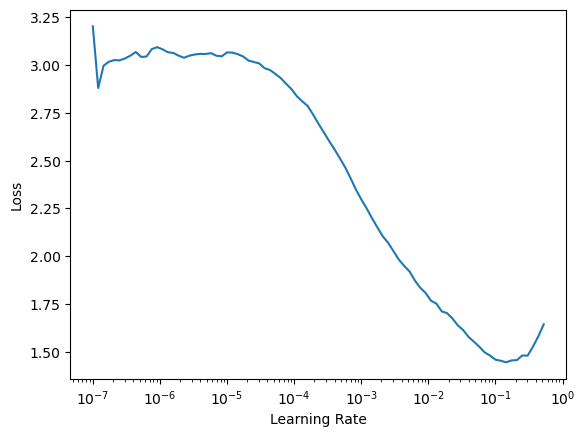

In [46]:
model.recorder.plot_lr_find()

In [49]:
best_lr

SuggestedLRs(valley=0.0005754399462603033)

In [47]:
lr1 = 1e-3
lr2 = 1e-1
model.fit_one_cycle(10,slice(lr1,lr2))

epoch,train_loss,valid_loss,accuracy,time
0,0.582431,0.484015,0.868000,50:57
1,0.869422,0.541371,0.887667,50:48
2,0.955923,7.437452,0.895000,50:55
3,0.739958,9.601765,0.898667,50:50
4,0.708788,3.835498,0.922000,50:23
5,0.440909,0.510563,0.916000,50:24
6,0.292559,0.347346,0.913333,50:28
7,0.201818,9.532511,0.930333,50:44
8,0.172214,0.747940,0.937000,50:35
9,0.158578,3.329756,0.933333,54:02


In [48]:
model.unfreeze()
model.fit_one_cycle(8,slice(1e-4,1e-3))

epoch,train_loss,valid_loss,accuracy,time


KeyboardInterrupt: 

In [ ]:
model.recorder.plot_loss()

In [ ]:
interp = ClassificationInterpretation.from_learner(model)
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(6,figsize = (25,5))

In [ ]:
# model.export(file = Path("/kaggle/working/export.pkl"))
# model.model_dir = "/kaggle/working"
# model.save("stage-1",return_path=True)

## TensorFlow

In [9]:
import tensorflow as tf

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    vertical_flip = True,
    rotation_range = 0.2,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    brightness_range = (0.2,1),
    fill_mode = 'nearest'
)

In [11]:
train_df = data.flow_from_directory(
    train_path,
    batch_size = 64,
    target_size = (225,225),
    class_mode = "sparse",
    shuffle = True,
)
val_df = data.flow_from_directory(
    val_path,
    batch_size = 64,
    target_size = (225,225),
    class_mode = "sparse", #ada sparse nanti outputya adalah 0 atau 1 atau 2 atau 3, kayak Label Encoder. ada juga binary, default categorical seperti one hot encoding
    shuffle = False
)

Found 9820 images belonging to 6 classes.
Found 4214 images belonging to 6 classes.


In [12]:
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

In [21]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, MaxPool2D, Conv2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import get_flops

ImportError: cannot import name 'get_flops' from 'tensorflow.keras' (c:\Users\untu0\anaconda3\Lib\site-packages\keras\_tf_keras\keras\__init__.py)

In [22]:
!pip uninstall keras-flops

^C


In [15]:
model.summary()
flops = get_flops(model, batch_size = 64)
print(f'FLOPS: {flops:,}')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 223, 223, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 223, 223, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,178,758 (42.64 MB)

 Trainable params: 11,178,182 (42.64 MB)

 Non-trainable params: 576 (2.25 KB)

NameError: name 'get_flops' is not defined

In [ ]:
if tf.config.experimental.list_physical_devices('GPU'):
    with tf.device('/GPU:0'):
        model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_df, validation_data=val_df, epochs=10, verbose=1)

Epoch 1/10
154/154 [==============================] - 130s 818ms/step - loss: 1.2585 - accuracy: 0.5354 - val_loss: 2.8805 - val_accuracy: 0.1917
Epoch 2/10
154/154 [==============================] - 124s 804ms/step - loss: 0.9261 - accuracy: 0.6410 - val_loss: 3.7751 - val_accuracy: 0.2231
Epoch 3/10
154/154 [==============================] - 128s 832ms/step - loss: 0.8225 - accuracy: 0.6864 - val_loss: 2.8303 - val_accuracy: 0.2406
Epoch 4/10
154/154 [==============================] - 128s 827ms/step - loss: 0.7552 - accuracy: 0.7123 - val_loss: 1.0757 - val_accuracy: 0.5982
Epoch 5/10
154/154 [==============================] - 121s 786ms/step - loss: 0.7200 - accuracy: 0.7266 - val_loss: 0.7845 - val_accuracy: 0.7114
Epoch 6/10
154/154 [==============================] - 122s 789ms/step - loss: 0.6878 - accuracy: 0.7392 - val_loss: 0.8472 - val_accuracy: 0.6948
Epoch 7/10
154/154 [==============================] - 116s 750ms/step - loss: 0.6481 - accuracy: 0.7605 - val_loss: 0.7526 -

In [52]:
set(history.history)

{'accuracy', 'loss', 'val_accuracy', 'val_loss'}

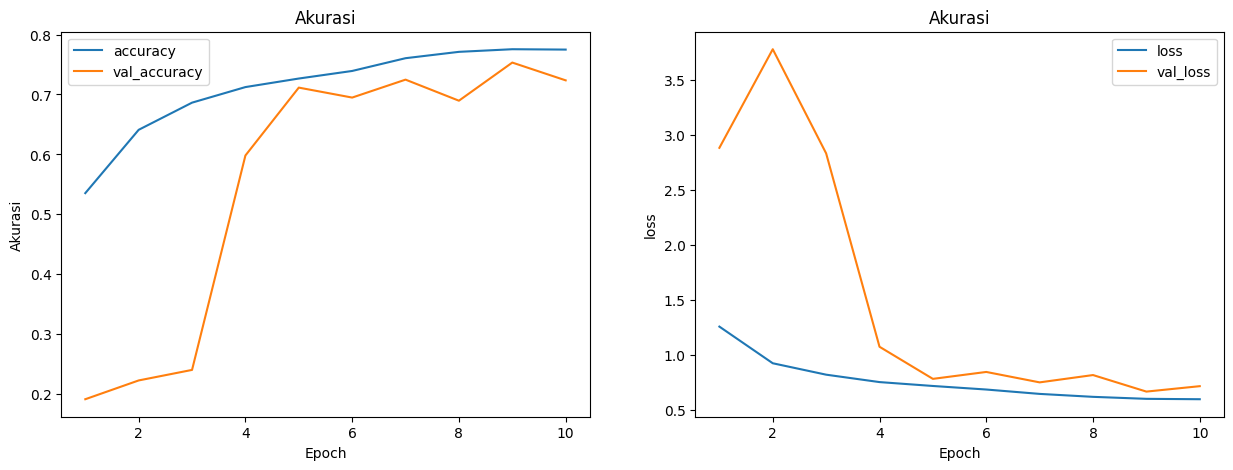

In [59]:

plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(range(1,11),history.history['accuracy'], label = "accuracy")
plt.plot(range(1,11),history.history['val_accuracy'], label = "val_accuracy")
plt.title("Akurasi")
plt.xlabel("Epoch")
plt.ylabel("Akurasi")
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1,11),history.history['loss'], label = "loss")
plt.plot(range(1,11),history.history['val_loss'], label = "val_loss")
plt.title("Akurasi")
plt.xlabel("Epoch")
plt.ylabel("loss")

plt.legend()


## Pytorch

In [1]:
import torch

: 

In [1]:
import torch

: 

In [ ]:
# from torch import flatten
# from torch.utils.data import DataLoader
# from torch.nn import Conv2d, MaxPool2d

In [ ]:
# train_torch = DataLoader(
#     train_path,
#     batch_size = 128,
#     resize = 1./255
# )